# Bayesian Data Analysis of Paper on Covid-19 & Blood Type

Alfred J. Reich, Ph.D.

## Summary

In the recent paper by Jiao Zhao, et al. (see reference below) it was reported that blood group (e.g., A, B, AB, or O) appears to have an effect on the likelihood of becoming infected with the Covid-19 virus.  Basically, people with blood type A appear to be more susceptible to the virus, while people with blood type O appear to be less susceptible.

The authors of the paper performed several types of statistical analyses to arrive at their conclusion: one-way ANOVA, 2-tailed $\chi^2$, and a meta-analysis using random effects models.

In this notebook, I've performed a different type of analysis, <b>Bayesian Data Analysis (BDA)</b>, using the data reported in their paper.

<u>CONCLUSION</u>: BDA supports their conclusion, but also provides posterior densities for the proportions of A, B, AB, and O blood groups among the infected, along with credible intervals for those proportions.  <b>See the four posterior density plots at the end of this notebook.</b>

## References

* <i><b>"Blood Type May Affect COVID-19 Risk: Study"</b></i> [WebMD](https://www.webmd.com/lung/news/20200320/blood-type-may-affect-covid19-risk-study)
* <i><b>"Relationship between the ABO Blood Group and the COVID-19 Susceptibility"</b></i> by Jiao Zhao, et al. [Abstract & link to PDF](https://www.medrxiv.org/content/10.1101/2020.03.11.20031096v1)

## Dependencies

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

# NOTE: arviz needs to be installed in the environment, but not imported directly

## Raw Data

<u><b>Excerpt from Zhao, et al:</b></u> <i>"The ABO group in 3694 normal people in Wuhan showed a distribution of 32.16%,
24.90%, 9.10% and 33.84% for A, B, AB and O, respectively, versus the distribution
of 37.75%, 26.42%, 10.03% and 25.80% for A, B, AB and O, respectively, in 1,775
COVID-19 patients from Wuhan Jinyintan Hospital. The proportion of blood group A
and O in COVID-19 patients were significantly higher and lower, respectively, than
    that in normal people (both P < 0.001)."</i>

In [2]:
# From Table 1 in the paper by Zhao, et al.

# NOTE: The four values in each of the 1x4 arrays below correspond
#       to blood type A, B, AB, and O, respectively.

# Controls (Wuhan Area), 3694 total:
wuhan_controls = np.array([1188, 920, 336, 1250])

# Wuhan Jinyintan Hospital
# Patients, 1775 total:
wuhan_patients = np.array([670, 469, 178, 458])
# Deaths, 206 total:
wuhan_deaths = np.array([85, 50, 19, 52])

# Renmin Hospital of Wuhan University
# patients, 113 total:
renmin_patients = np.array([45, 25, 15, 28])

# Controls (Shenzhen area), 23386 total:
shenzhen_controls = np.array([6728, 5880, 1712, 9066])

# Patients from Shenzhen Third People's Hospital, 285 total:
shenzhen_patients = np.array([82, 83, 39, 81])

In [3]:
# Wuhan Controls Distribution
print(f"Wuhan Controls Total: {wuhan_controls.sum()}")

wuhan_controls_dist = wuhan_controls / wuhan_controls.sum()
print(f"Wuhan Controls Distribution:\n  [A, B, AB, O] = {wuhan_controls_dist}")

Wuhan Controls Total: 3694
Wuhan Controls Distribution:
  [A, B, AB, O] = [0.3216026  0.24905252 0.09095831 0.33838657]


In [4]:
sick_or_dead = wuhan_patients + wuhan_deaths + renmin_patients + shenzhen_patients
print(sick_or_dead)
print(f"Total = {sick_or_dead.sum()}")

[882 627 251 619]
Total = 2379


## Bayesian Data Analysis

The sick & dead results are modeled as Multinomial random variable with a Dirichlet prior, initialized using the Wuhan control data.

theta0, theta1, theta2, and theta3 coorespond to blood groups A, B, AB, and O, respectively.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:10<00:00, 4633.81draws/s]


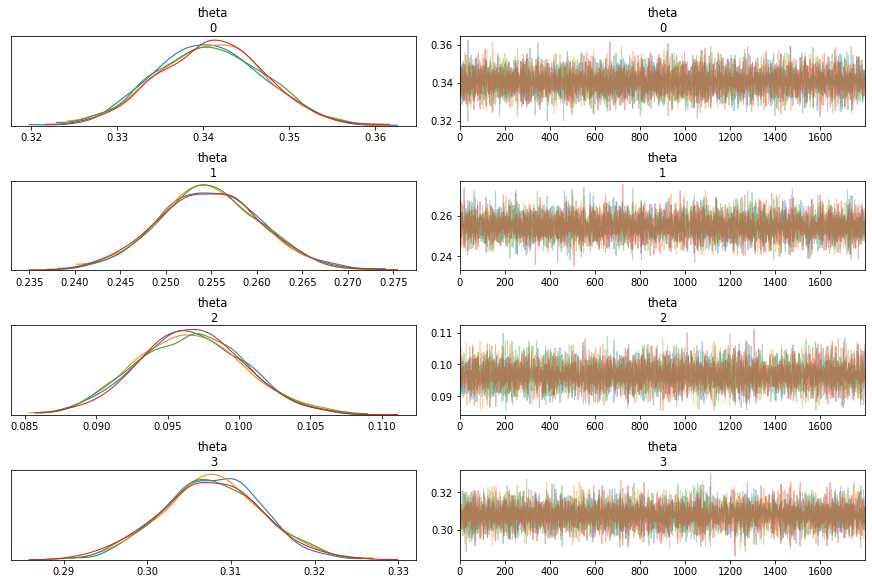

In [5]:
with pm.Model() as mod:
    theta = pm.Dirichlet('theta', a=wuhan_controls)
    post = pm.Multinomial('Posterior', n=sick_or_dead.sum(), p=theta, observed=sick_or_dead)
    trace = pm.sample(2000, tune=10000)
    pm.traceplot(trace[200:], lines={'theta':theta})

In [6]:
pm.summary(trace, alpha=0.01)

,mean,sd,mc_error,hpd_0.5,hpd_99.5,n_eff,Rhat
theta__0,0.340843,0.006197,0.000059,0.325500,0.356071,12248.347755,0.999962
theta__1,0.254801,0.005608,0.000051,0.240716,0.269341,11857.945691,1.000002
theta__2,0.096651,0.003786,0.000034,0.087452,0.106530,11830.315284,0.999810
theta__3,0.307705,0.005927,0.000053,0.291423,0.321825,11590.919971,1.000002


## Posterior Density Estimates

In the four plots shown below, theta0, theta1, theta2, and theta3 coorespond to blood groups A, B, AB, and O, respectively, of the infected & deceased patients.  The vertical, orange <i>reference lines</i> in each plot are the Wuhan controls distribution values, along with the probabilities below and above those values as determined by the respective posterior density estimates.  The dark horizontal bars are 99% Highest Posterior Density (HPD) Intervals (<i>"credible intervals"</i>).

Note that, for theta0, the reference bar is far to the left of HPD-0, and, for theta3, the reference bar is far to the right of HPD-3. So, as Jiao Zhao, et al. determined, blood type A appears to have a much higher susceptibility to the Covid-19 virus, while the susceptibility of blood type O appears to be much lower.

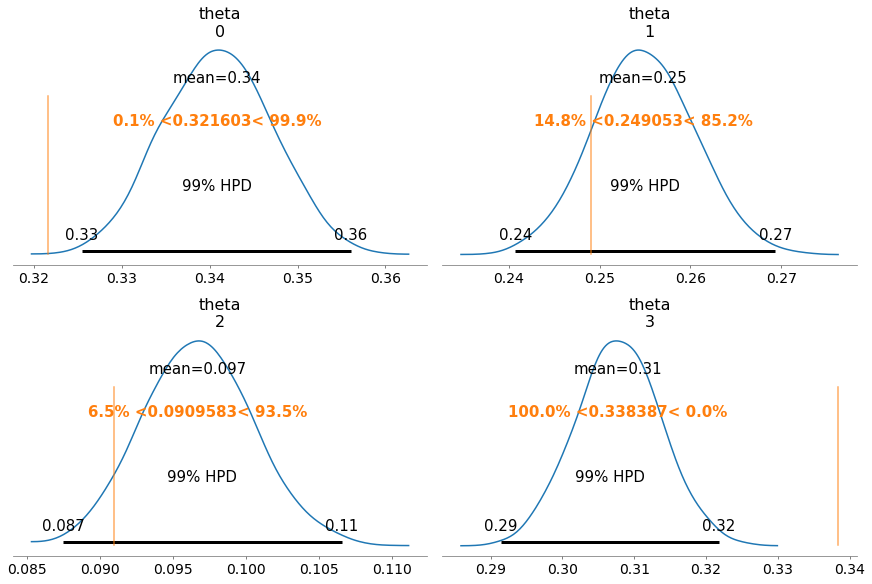

In [7]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), constrained_layout=True)
_ = pm.plot_posterior(trace, credible_interval=0.99, ax=axes,
                      ref_val=list(wuhan_controls_dist))